In [1]:
import autokeras as ak
import tensorflow as tf
from tensorflow.keras.datasets import cifar10 
import matplotlib.pyplot as plt

In [2]:
# check GPU is available
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-03-02 17:06:09.811950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 17:06:15.020584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14639 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2022-03-02 17:06:15.022408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14639 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1c:00.0, compute capability: 7.0
2022-03-02 17:06:15.023989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14639 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0

True

# Preparing the CIFAR-10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train: ', x_train.shape) 
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape) 
print('y_test: ', y_test.shape)

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
x_test:  (10000, 32, 32, 3)
y_test:  (10000, 1)


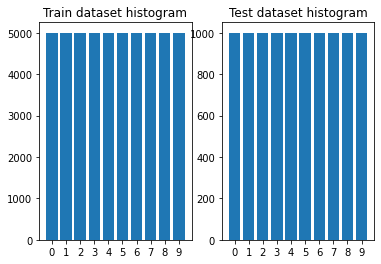

In [4]:
import numpy as np

train_histogram = np.histogram(y_train)
test_histogram = np.histogram(y_test)
_, axs = plt.subplots(1, 2)
axs[0].set_xticks(range(10))
axs[0].bar(range(10), train_histogram[0])
axs[0].set_title('Train dataset histogram')
axs[1].set_xticks(range(10))
axs[1].bar(range(10), test_histogram[0])
axs[1].set_title('Test dataset histogram')
plt.show()

# Automodel

In [7]:
# callbacks
callbacks = [ tf.keras.callbacks.EarlyStopping(patience=2) ]

# node costruction
# image input
input_node = ak.ImageInput()

# main model layers 
# efficient = EfficientNet
output_node = ak.Normalization()(input_node) # normalization
output_node = ak.EfficientNetBlock(version='b7',
                                   pretrained=True)(output_node)

output_node = ak.SpatialReduction(reduction_type='global_avg')(output_node) # pooling 

# classification layer
output_node = ak.ClassificationHead(dropout=0)(output_node) # dropout=0

# compile & fit
model = ak.AutoModel(inputs=input_node, 
                     outputs=output_node, 
                     # tuner='bayesian',
                     max_trials=2)

# Multi Strategy

In [5]:
# 在所有GPU上設定同步策略
mirrored_strategy = tf.distribute.MirroredStrategy()

2022-03-02 17:09:08.724258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14639 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2022-03-02 17:09:08.727544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14639 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1c:00.0, compute capability: 7.0
2022-03-02 17:09:08.730861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14639 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2022-03-02 17:09:08.734132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14639 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [8]:
with mirrored_strategy.scope():
    model = model

model.fit(x_train, y_train,
          batch_size=128,
          callbacks=callbacks,
          epochs=10)

Trial 2 Complete [00h 05m 25s]
val_loss: 1.183217167854309

Best val_loss So Far: 1.183217167854309
Total elapsed time: 00h 08m 29s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
391/391 [==============================] - 93s 153ms/step - loss: 1.3902 - accuracy: 0.5124
Epoch 2/10
391/391 [==============================] - 60s 153ms/step - loss: 0.6008 - accuracy: 0.8030
Epoch 3/10
391/391 [==============================] - 59s 151ms/step - loss: 0.3464 - accuracy: 0.8867
Epoch 4/10
391/391 [==============================] - 58s 147ms/step - loss: 0.2083 - accuracy: 0.9320
Epoch 5/10
391/391 [==============================] - 59s 150ms/step - loss: 0.1322 - accuracy: 0.9575
Epoch 6/10
391/391 [==============================] - 58s 149ms/step - loss: 0.0798 - accuracy: 0.9745
Epoch 7/10
391/391 [==============================] - 58s 149ms/step - loss: 0.0458 - accuracy: 0.9858
Epoch 8/10
391/391 [==============================] - 58s 149ms/step - loss: 0.0256 - accuracy: 0.9919
Epoch 

2022-03-02 17:31:31.986909: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


# Evaluate

In [10]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 24s 62ms/step - loss: 0.7790 - accuracy: 0.8785


[0.7790425419807434, 0.8784999847412109]

In [13]:
# 觀察每張GPU分布運算情形, 原先batch_size為128, 有時遇到記憶體限制會自動調降, 平均分到8張GPU後,每個step各自負責64/8=8筆資料
mirrored_strategy.num_replicas_in_sync

8